---
title: "Stuff+"
subtitle: "MLB Pitcher Evaluation by Stabilized Metric"
description: "Implementation of a metric for evaluating pitch performance, focusing on analyzing Whiff%"
date: 2024-06-10
categories: ["Statistics"]
author: "Sung Woo Bak & Adam Hetherwick"
draft: false
image: "../img/stuff.png"
layout: "article"
toc: true
---



In evaluating a pitcher's performance, various metrics such as ERA, WHIP, FIP, and SIERA are commonly used. However, these metrics can introduce noise and become less reliable, especially when the sample size is small. This project aims to define a stabilized metric that offers a more consistent and reliable method of assessing a pitcher's performance.

**Stuff+** is a metric that focuses on evaluating each pitch by considering physical factors such as pitch location, speed, spin rate, and more. Unlike other metrics, which provide an overall performance, Stuff+ offers insights into the effectiveness of each individual pitch. This metric was conceptualized by Max Bay and Eno Sarris, and many people have created and tested their own Stuff+ models.

For more details about Stuff+, refer to the link provided below.

- https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/


In [1]:
#| echo: false
#| warning: false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import io
import contextlib

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# API/Data
from pybaseball import statcast, pitching_stats, statcast_pitcher, playerid_lookup
import pybaseball

### Data

The data used in this project is from **Statcast**, accessed via pybaseball, and includes every pitch from the 2023 MLB season.


In [2]:
#| echo: false
#| warning: false

# Data 

# pybaseball statcast
start_date = '2023-03-29'
end_date = '2023-10-02'
pybaseball.cache.enable()

f = io.StringIO() # Remove message
with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    statcast_data = statcast(start_dt=start_date, end_dt=end_date)

# Pitch data
interested_columns = ['player_name', 'pitch_name', 'description', 'release_speed', 'release_pos_x', 'release_pos_z', 'p_throws',
                    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
                    'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y',  'spin_axis', 'delta_run_exp']

pitch = statcast_data[interested_columns]

# Drop NA
na_counts = pitch.isna().sum()
na_counts_list = [(column, na_count) for column, na_count in na_counts.items()]
pitch = pitch.dropna()

# Drop pitch types with small size
temp = ['Slurve', 'Other', 'Forkball', 'Eephus', 'Knuckleball', 'Screwball', 'Slow Curve']
pitch = pitch[~pitch['pitch_name'].isin(temp)]

# Convert p_throws to num value
pitch['p_throws'] = pitch['p_throws'].apply(lambda x: 1 if x == 'R' else 0)

# Label categorical
pitch['pitch_name_label'] = pitch['pitch_name'].astype('category').cat.codes
pitch['description_label'] = pitch['description'].astype('category').cat.codes

pitch.head()

# Whiff%
whiff_total = ['hit_into_play', 'foul', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip']
whiff_criteria = ['swinging_strike', 'swinging_strike_blocked', 'missed_bunt']
whiff_df = pitch[pitch['description'].isin(whiff_total)]
whiff_df['whiff'] = whiff_df['description'].apply(lambda x: 1 if x in whiff_criteria else 0)

# CS plus Whiff
csw_total = ['hit_into_play', 'foul', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip', 'called_strike']
csw_criteria = ['swinging_strike', 'missed_bunt', 'swinging_strike_blocked', 'called_strike']
csw_df = pitch[pitch['description'].isin(csw_total)]
csw_df['csw'] = csw_df['description'].apply(lambda x: 1 if x in csw_criteria else 0)

# CS
cs_criteria = ['called_strike']
pitch['cs'] = pitch['description'].apply(lambda x: 1 if x in cs_criteria else 0)

# Data frame for each pitch type
grouped = whiff_df.groupby('pitch_name')
pitch_dfs = {}
for p, group in grouped:
    pitch_dfs[p] = group

pitch.head()

C:\Users\User\AppData\Local\Temp\ipykernel_12208\1087934578.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whiff_df['whiff'] = whiff_df['description'].apply(lambda x: 1 if x in whiff_criteria else 0)


C:\Users\User\AppData\Local\Temp\ipykernel_12208\1087934578.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csw_df['csw'] = csw_df['description'].apply(lambda x: 1 if x in csw_criteria else 0)


,player_name,pitch_name,description,release_speed,release_pos_x,release_pos_z,p_throws,pfx_x,pfx_z,plate_x,...,az,effective_speed,release_spin_rate,release_extension,release_pos_y,spin_axis,delta_run_exp,pitch_name_label,description_label,cs
2421,"Robertson, Nick",Changeup,hit_into_play,89.0,-2.8,5.59,1,-1.53,0.33,0.33,...,-27.922064,90.7,1703,7.4,53.11,250,-0.09,1,8,0
2500,"Robertson, Nick",4-Seam Fastball,foul,96.9,-2.4,5.9,1,-0.76,1.36,0.09,...,-12.836434,98.4,2153,7.4,53.13,211,0.0,0,4,0
2593,"Robertson, Nick",Changeup,ball,90.0,-2.93,5.56,1,-1.65,0.36,-0.24,...,-26.599717,91.5,1698,7.4,53.14,250,0.016,1,0,0
2643,"Robertson, Nick",Sweeper,ball,82.2,-3.09,5.55,1,1.43,0.28,0.81,...,-28.491928,82.4,2786,6.9,53.63,58,0.009,8,0,0
2790,"Robertson, Nick",Changeup,swinging_strike,89.2,-2.87,5.58,1,-1.49,0.31,-0.78,...,-28.148796,90.5,1589,7.2,53.29,257,-0.023,1,10,0


### Distributions of Pitch-Related Variables

Details about the variables can be found at the link below.

- https://baseballsavant.mlb.com/csv-docs


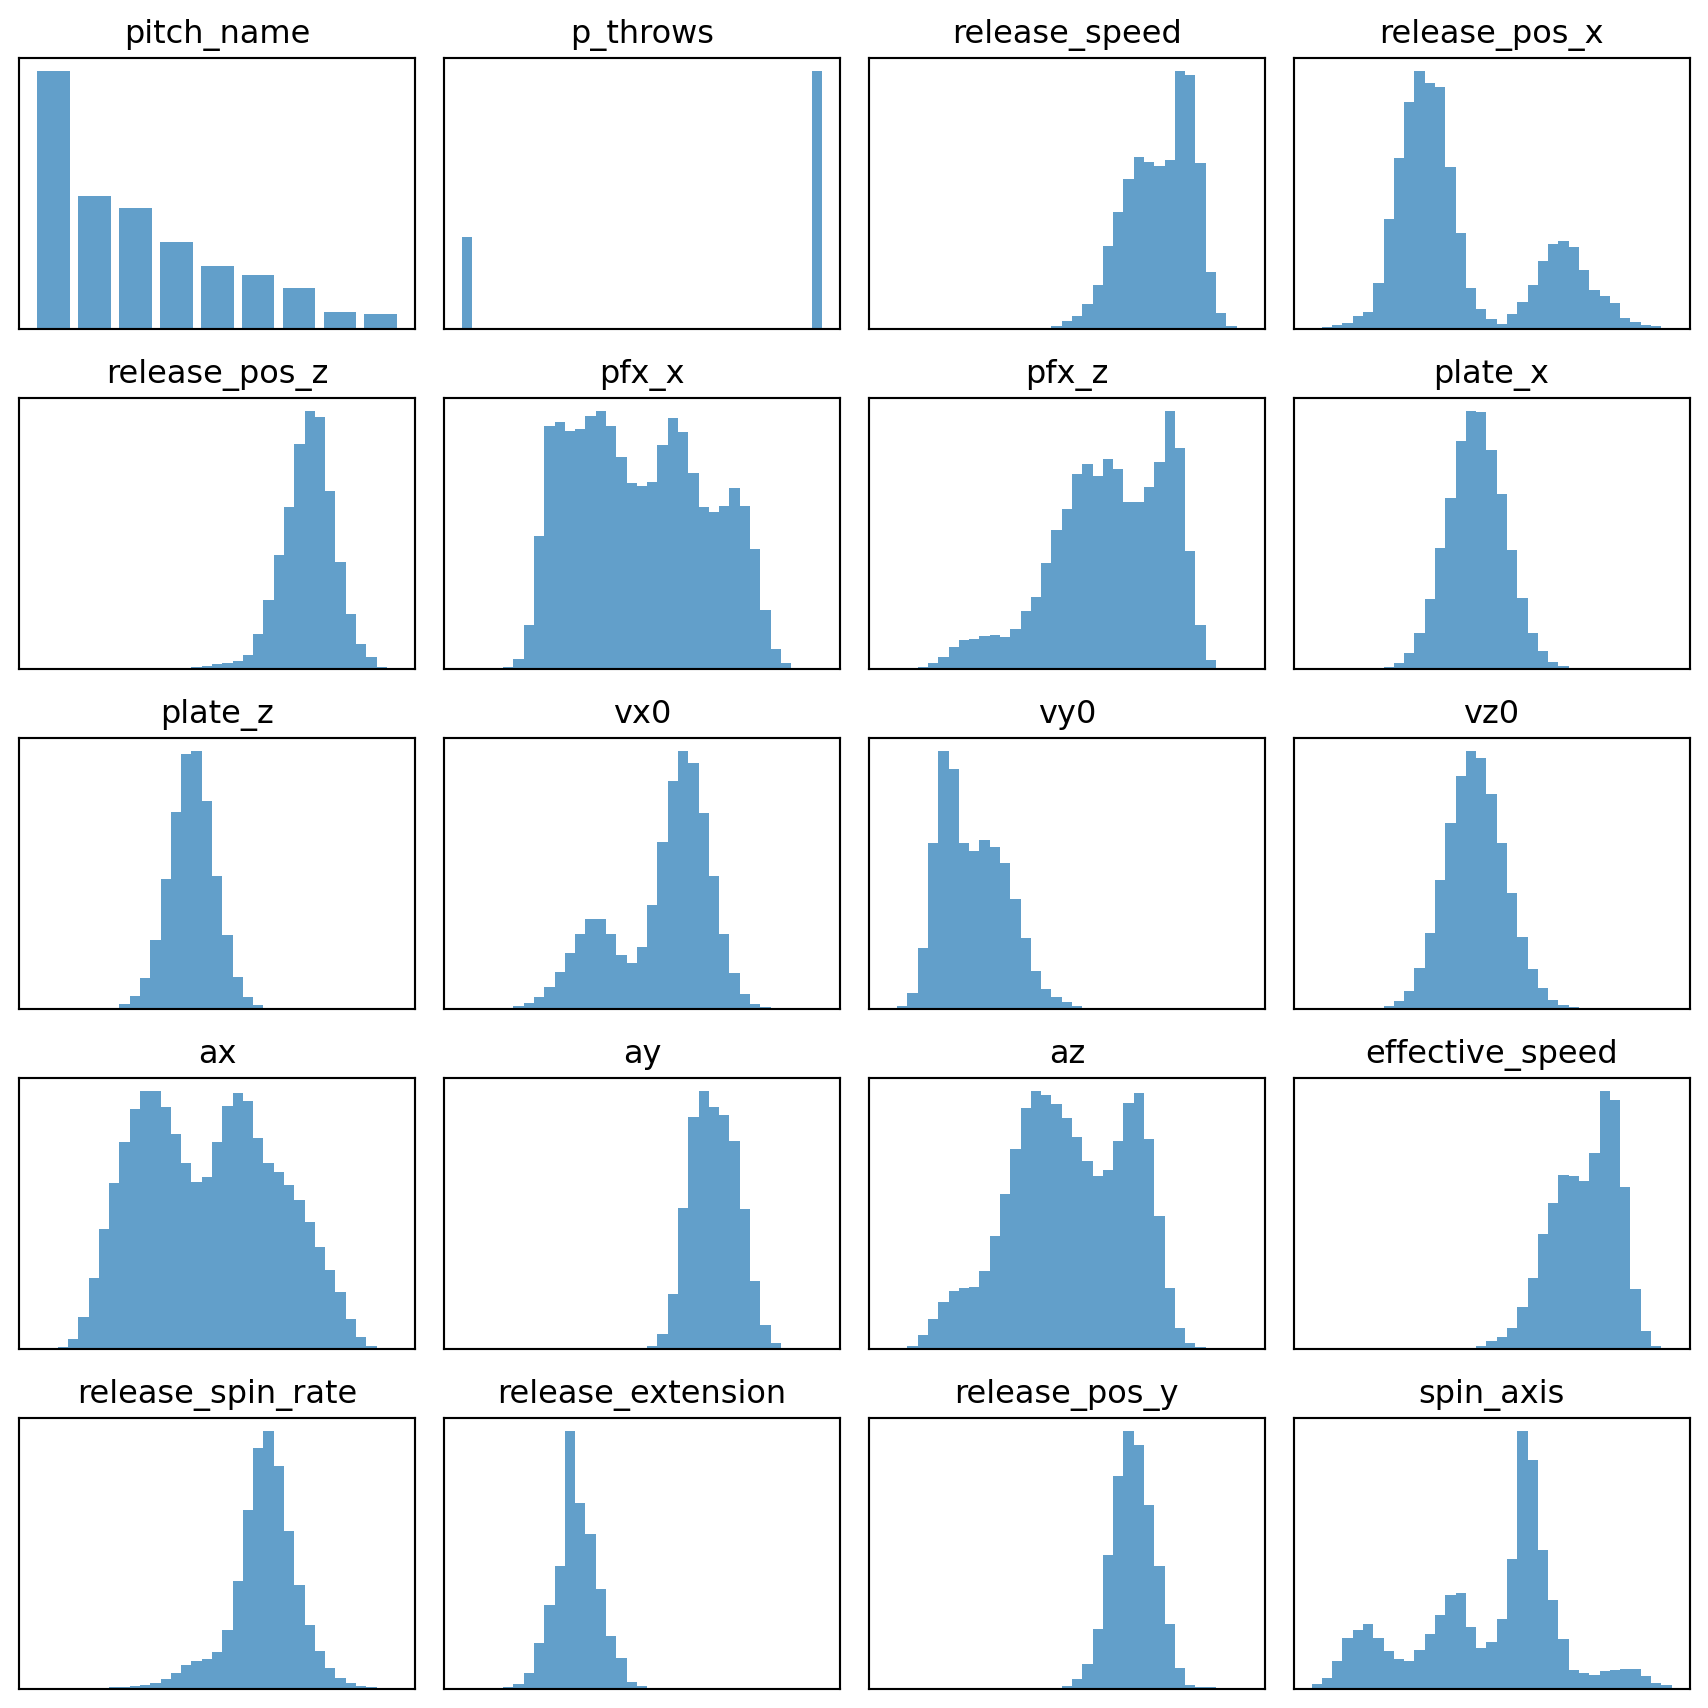

In [3]:
#| echo: false
#| warning: false
#| column: body-outset

# Distributions of all variables

dist_df = pitch[['pitch_name', 'p_throws', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x',
                 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis']]

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(9, 9))
axes = axes.flatten()

for ax, column in zip(axes, dist_df.columns):
    if pd.api.types.is_numeric_dtype(dist_df[column]):
        ax.hist(dist_df[column], bins=35, alpha=0.7)
    else:
        counts = dist_df[column].value_counts()
        ax.bar(counts.index, counts.values, alpha=0.7)

    ax.set_title(f'{column}')
    ax.set_xticks([])
    ax.set_yticks([]) 

plt.tight_layout()
plt.show()

The plots above provide an overview of the data. It allows a better understanding of the data's structure and distribution. 


### Method


To define Stuff+, the metrics, such as spin rate, horizontal and vertical break, and other pitch characteristics were considered as covariates and CS% (Called Strike Percentage), CSW% (Called Strike + Whiff Percentage), strikeout percentage (K%), and changes in run expectancy as the corresponding response indicators that represent the performance of the pitches. However, after evaluating the consistency of these metrics, Whiff% was chosen as the primary indicator.

In this project, Stuff+ was defined using the following formula.

$$
\text{Stuff+} = \frac{\text{Predicted Whiff\%}}{\text{mean League predicted Whiff\%}} \cdot 100
$$

and Whiff% is computed as follows

$$
\text{Whiff\%} = \frac{\text{Missed Swings (swinging strike, swinging strike blocked, missed bunt)}}{\text{Total Swing Attempts}}
$$

This Predicted Whiff% is used to ensure stable outputs because it relies on probability. This approach is based on the methodologies referenced from A. Jon (2023), Cameron Grove (2021), and RG Pitching (2023).

To find the Predicted Whiff%, Logistic Regression, XGBoost, and Random Forest were considered. Although algorithms like XGBoost were more robust compared to Random Forest, Logistic Regression provided the most consistent and reliable results. Therefore, Logistic Regression was to predict Whiff% in this project.


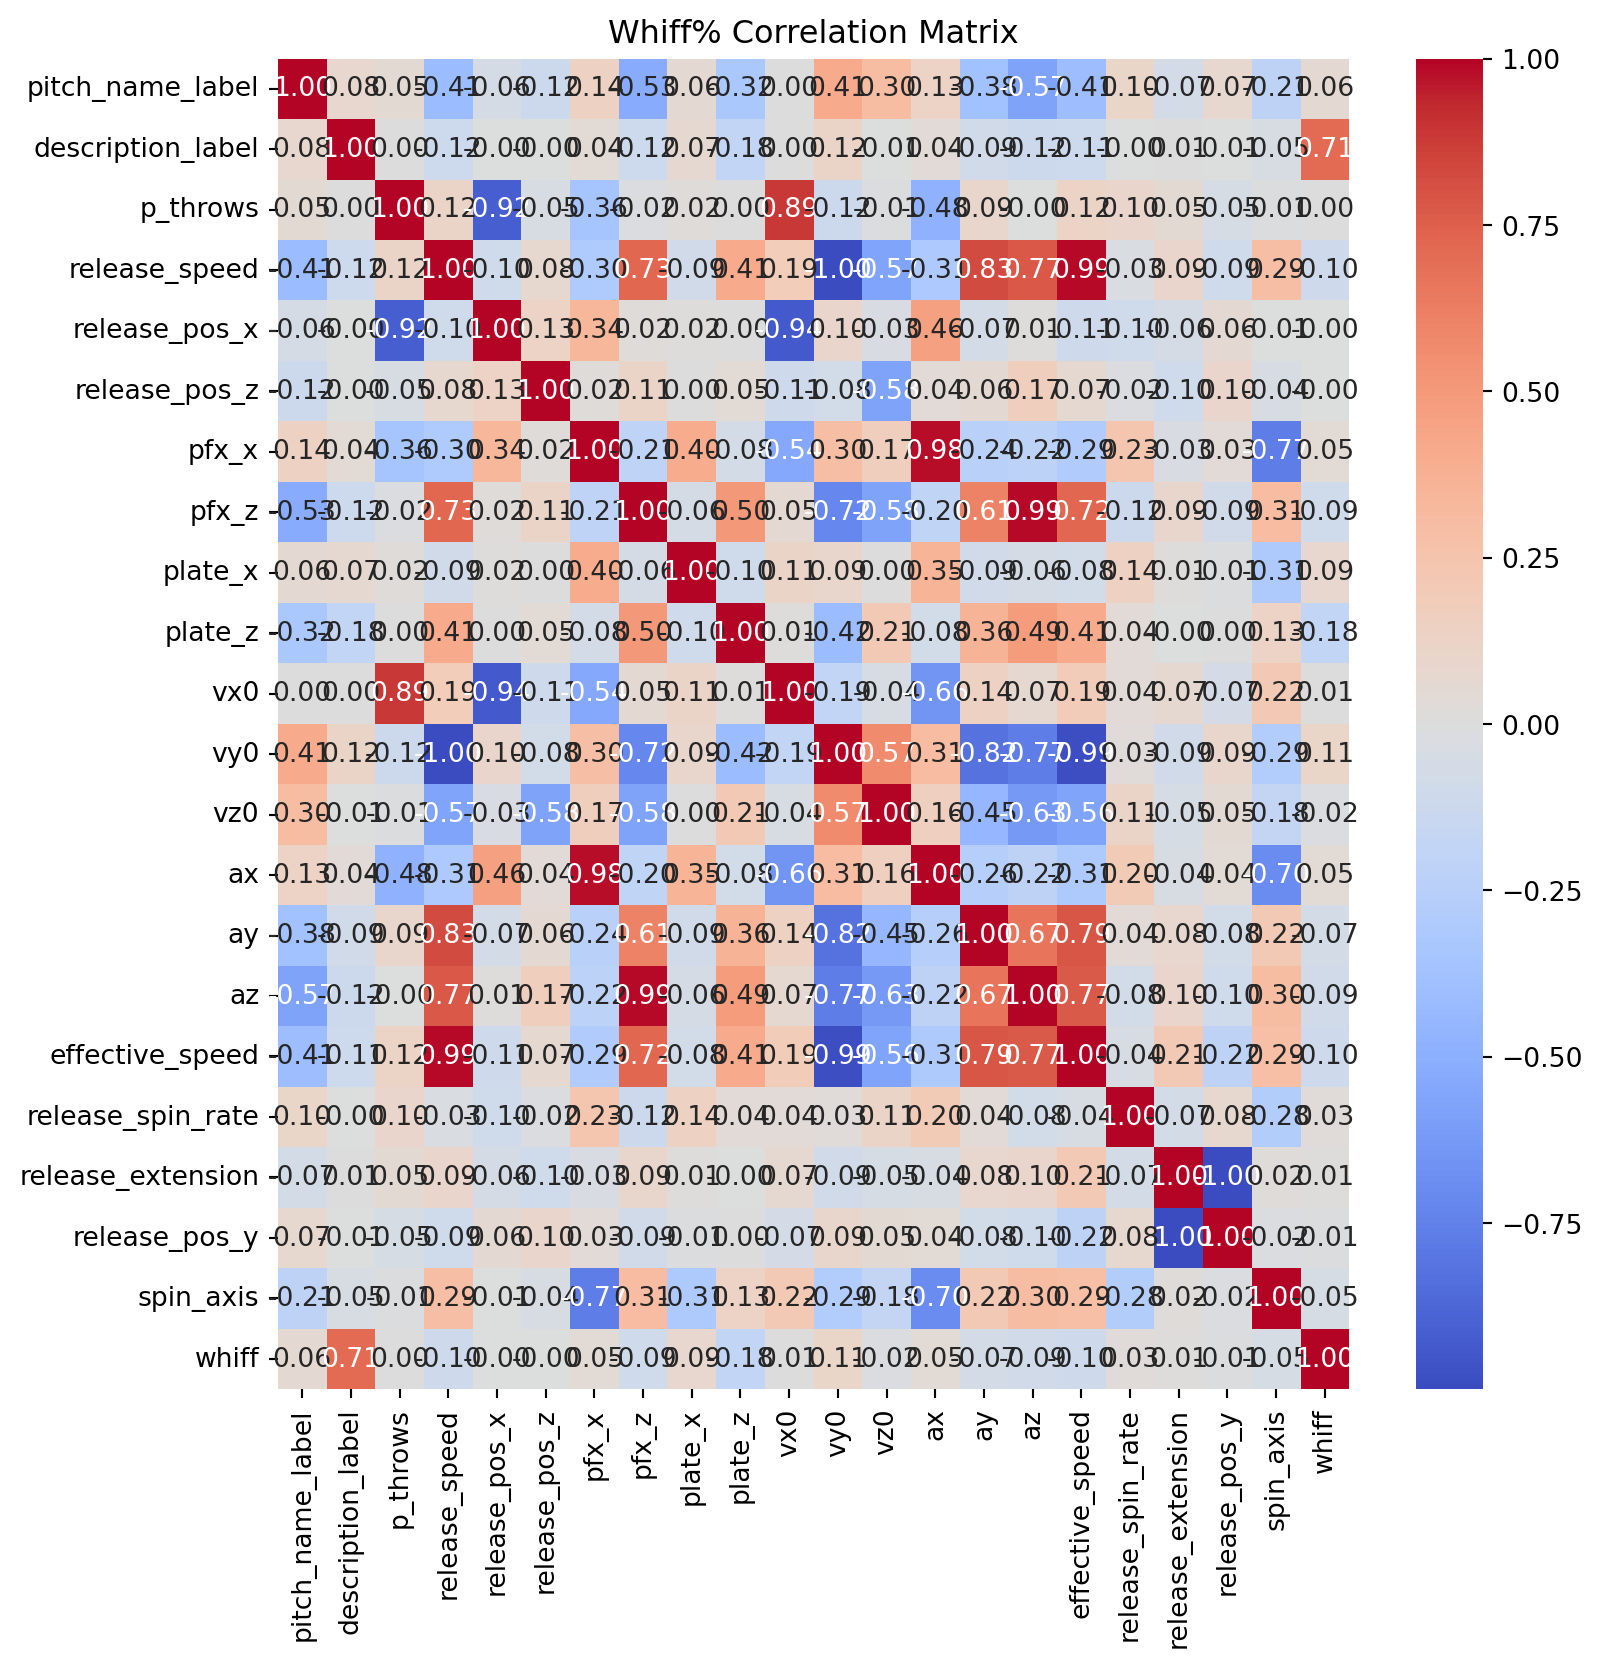

In [4]:
#| echo: false
#| warning: false
#| column: body-outset

# Correlation Matrix

# Whiff corr matrix
whiff_corr = whiff_df[['pitch_name_label', 'description_label', 'p_throws', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x',
                       'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis', 'whiff']]
whiff_mat = whiff_corr.corr()

plt.figure(figsize=(9, 9))
sns.heatmap(whiff_mat, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Whiff% Correlation Matrix')

plt.show()

The plot above shows the correlation matrix, with the last row and column representing Whiff%.


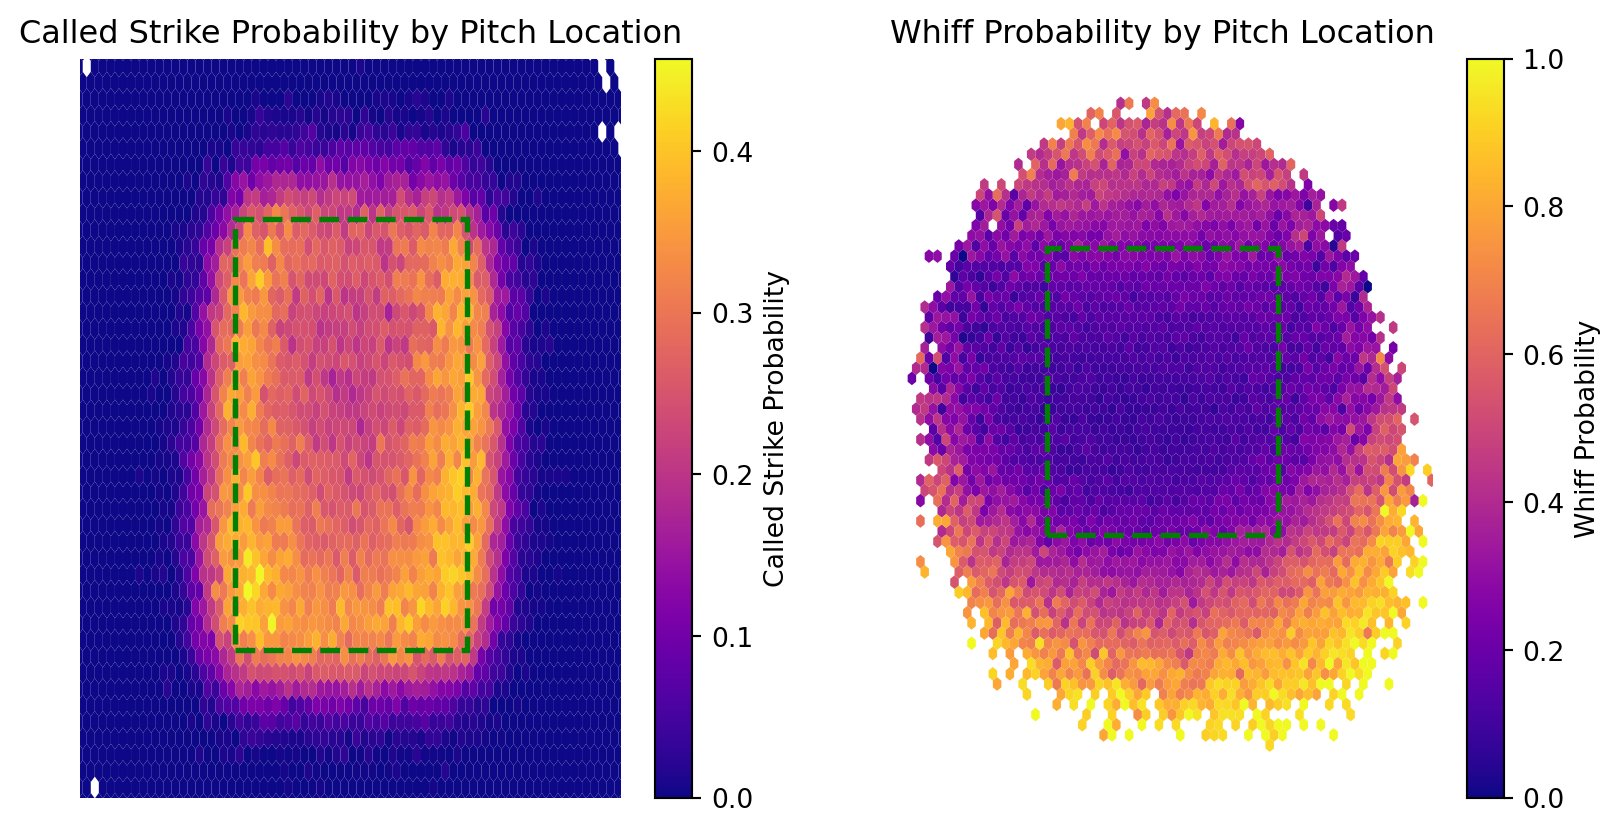

In [5]:
#| echo: false
#| warning: false
#| column: body-outset

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

hb1 = ax1.hexbin(pitch['plate_x'], pitch['plate_z'], C=pitch['cs'], gridsize=200, cmap='plasma', edgecolors=None, mincnt=10)
ax1.axis('off')
ax1.set_xlim(-1.75, 1.75)
ax1.set_ylim(1, 4)
ax1.set_xlabel('plate_x')
ax1.set_ylabel('plate_y')
ax1.set_title('Called Strike Probability by Pitch Location')
cb1 = fig.colorbar(hb1, ax=ax1, label='Called Strike Probability')

hb2 = ax2.hexbin(whiff_df['plate_x'], whiff_df['plate_z'], C=whiff_df['whiff'], gridsize=100, cmap='plasma', edgecolors=None, mincnt=10)
ax2.axis('off')
ax2.set_xlim(-1.75, 1.75)
ax2.set_ylim(0, 4.5)
ax2.set_xlabel('plate_x')
ax2.set_ylabel('plate_y')
ax2.set_title('Whiff Probability by Pitch Location')
cb2 = fig.colorbar(hb2, ax=ax2, label='Whiff Probability')

strike_zone_coords = (-0.75, 1.6)  # Bottom-left corner of the strike zone
strike_zone_width = 1.5  # Width of the strike zone
strike_zone_height = 1.75  # Height of the strike zone

# Draw strike zone box for ax1
strike_zone_ax1 = Rectangle(strike_zone_coords, strike_zone_width, strike_zone_height, linestyle='--', linewidth=2, edgecolor='green', facecolor='none')
ax1.add_patch(strike_zone_ax1)

# Draw strike zone box for ax2
strike_zone_ax2 = Rectangle(strike_zone_coords, strike_zone_width, strike_zone_height, linestyle='--', linewidth=2, edgecolor='green', facecolor='none')
ax2.add_patch(strike_zone_ax2)
plt.show()

The plots above show CS% (Called Strike Percentage) and Whiff% based on different pitch locations.


### Stuff+


In [6]:
#| echo: false
#| warning: false

# Stuff+

def stuff_plus_log(pitch_data):
    X = pitch_data[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
                    'vx0', 'vy0', 'vz0', 'ax', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis']]
    y = pitch_data['whiff']


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression(max_iter=500, solver='saga')
    model.fit(X_scaled, y)


    pitch_data['stuff+'] = model.predict_proba(X_scaled)[:, 1]
    league_average = pitch_data['stuff+'].mean()
    pitch_data['stuff+'] = (pitch_data['stuff+'] / league_average) * 100

    return pitch_data

pitch_types = ['4-Seam Fastball', 'Changeup', 'Curveball', 'Cutter', 'Knuckle Curve', 'Sinker', 'Slider', 'Split-Finger', 'Sweeper']
log_df = {}

for pitch in pitch_types:
    log_df[pitch] = stuff_plus_log(pitch_dfs[pitch])

In [7]:
#| echo: false
#| warning: false

# Standardize Stuff+
def calculate_stuff_mean(pitch_df, pitch_name):
    return pitch_df.groupby('player_name')['stuff+'].mean().reset_index()

pitch_types = {
    'fastball': log_df['4-Seam Fastball'],
    'changeup': log_df['Changeup'],
    'curveball': log_df['Curveball'],
    'cutter': log_df['Cutter'],
    'knuckle': log_df['Knuckle Curve'],
    'sinker': log_df['Sinker'],
    'slider': log_df['Slider'],
    'splitter': log_df['Split-Finger'],
    'sweeper': log_df['Sweeper']
}

stuff_plus_df = {name: calculate_stuff_mean(data, name) for name, data in pitch_types.items()}

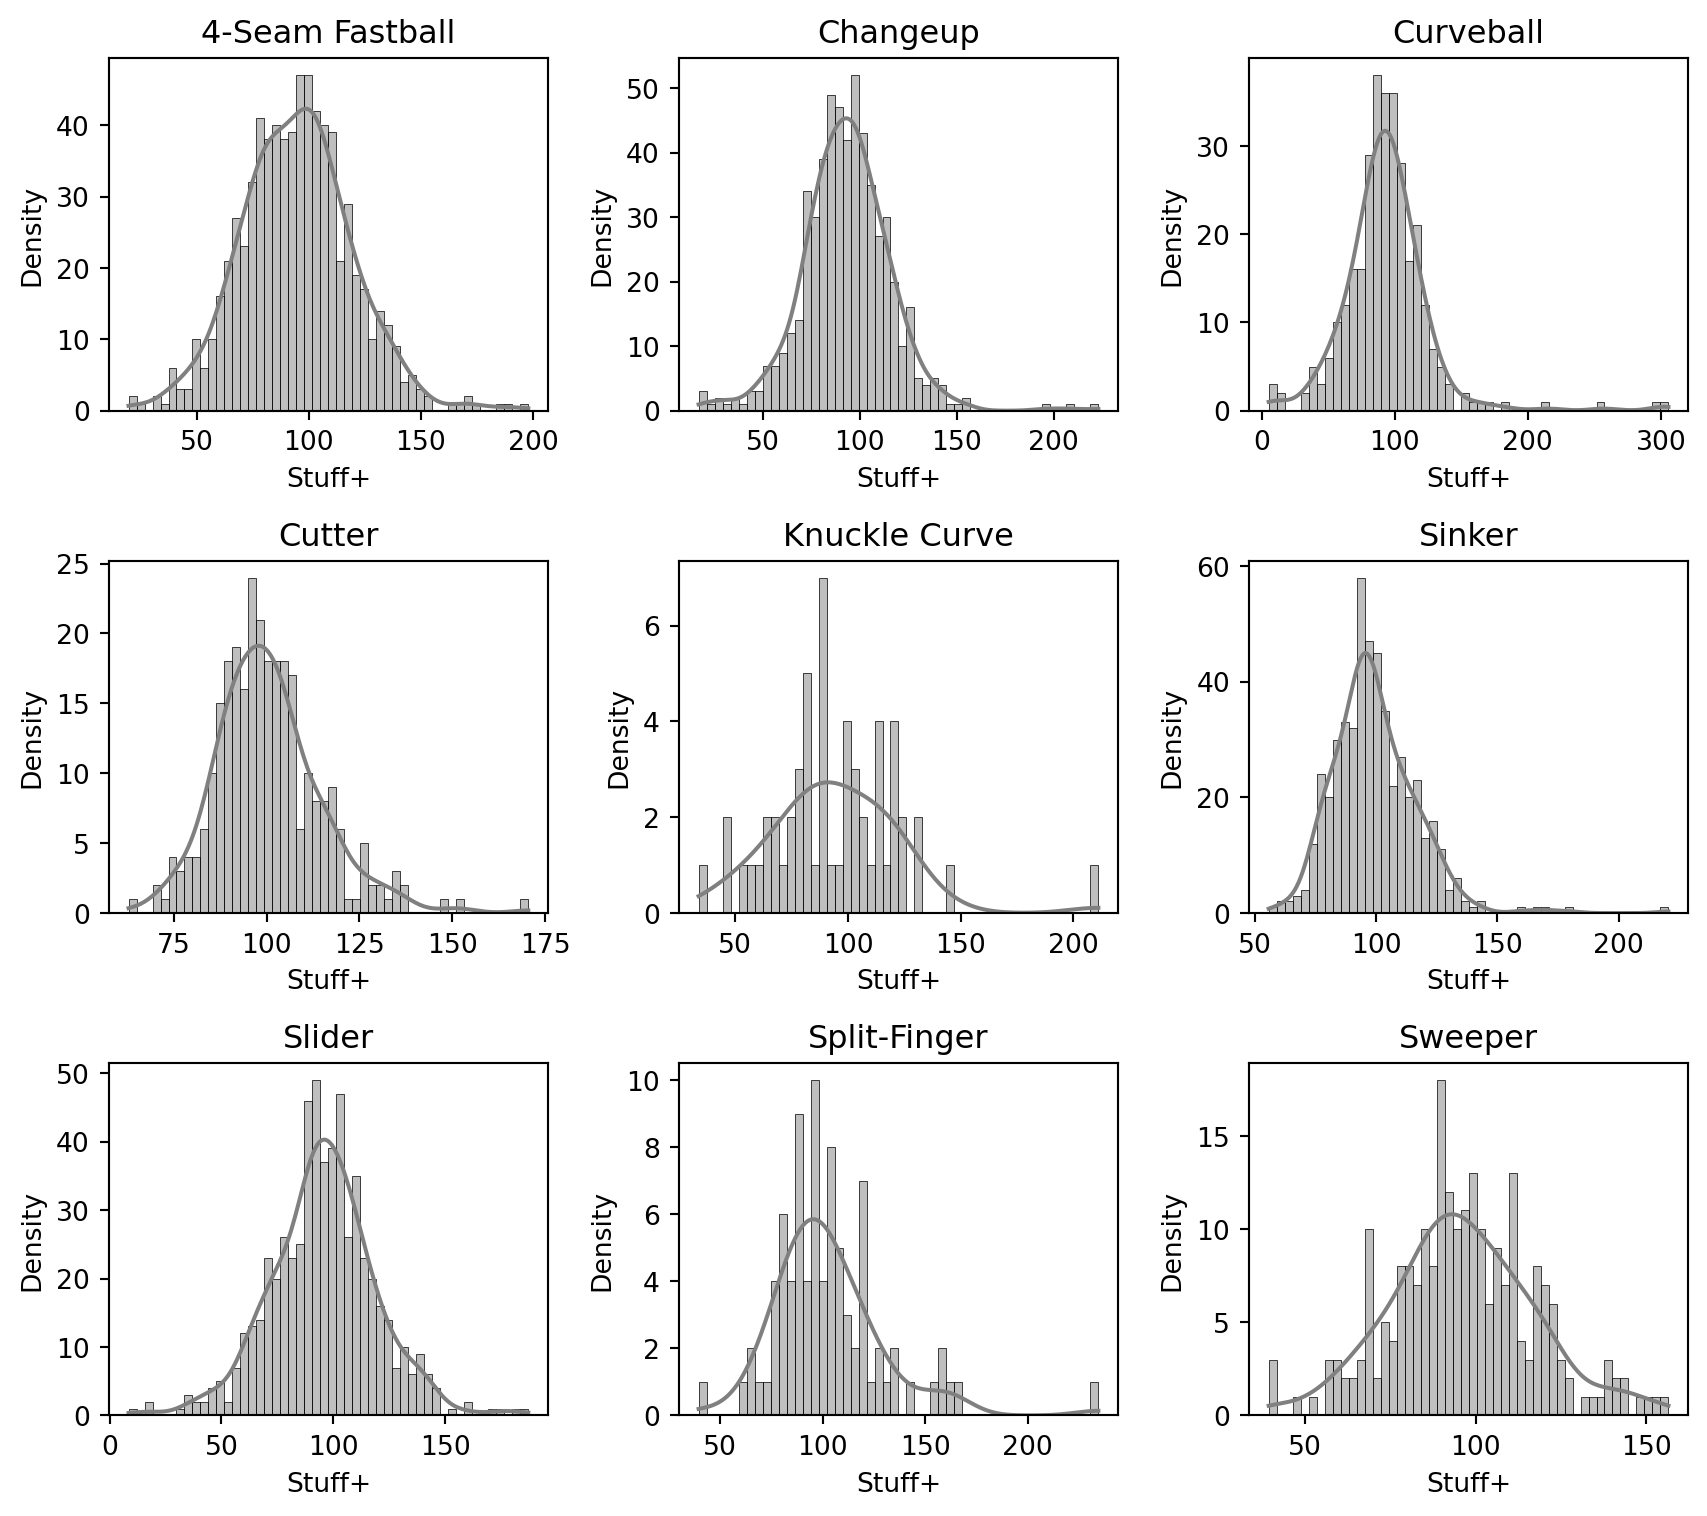

In [8]:
#| echo: false
#| warning: false
#| column: body-outset

# Stuff+ Distribution
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 8))
axes = axes.flatten()

pitch_display_names = {
    'fastball': '4-Seam Fastball',
    'changeup': 'Changeup',
    'curveball': 'Curveball',
    'cutter': 'Cutter',
    'knuckle': 'Knuckle Curve',
    'sinker': 'Sinker',
    'slider': 'Slider',
    'splitter': 'Split-Finger',
    'sweeper': 'Sweeper'
}

for ax, (pitch_name, data) in zip(axes, stuff_plus_df.items()):
    sns.histplot(data['stuff+'], bins=50, kde=True, color='gray', ax=ax)
    ax.set_title(pitch_display_names[pitch_name])
    ax.set_xlabel('Stuff+')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

The plot above displays the standardized Stuff+ for each pitch type. Each Stuff+ value is centered around 100.


In [9]:
#| echo: false
#| warning: false

# Stuff+ for selected pitchers
pitchers = ['Abbott, Andrew', 'Corbin, Patrick', 'Scherzer, Max', 'Darvish, Yu', 'Sears, JP']

sample_stuff_plus = pd.DataFrame()

for key, df in stuff_plus_df.items():
    temp = []
    for p in pitchers:
        if not df[df['player_name'] == p].empty:
            temp.append(df[df['player_name'] == p]['stuff+'].iloc[0])
        else:
            temp.append(float('nan'))

    sample_stuff_plus[pitch_display_names[key]] = temp

sample_stuff_plus = sample_stuff_plus.round().astype('Int64')
sample_stuff_plus['Pitcher'] = pitchers
sample_stuff_plus = sample_stuff_plus.set_index('Pitcher')

sample_stuff_plus.T

Pitcher,"Abbott, Andrew","Corbin, Patrick","Scherzer, Max","Darvish, Yu","Sears, JP"
4-Seam Fastball,106,68,106,117,111
Changeup,87,128,90,<NA>,80
Curveball,101,<NA>,107,97,<NA>
Cutter,<NA>,<NA>,117,102,<NA>
Knuckle Curve,<NA>,<NA>,<NA>,90,<NA>
Sinker,<NA>,105,<NA>,101,117
Slider,<NA>,132,117,90,84
Split-Finger,<NA>,<NA>,<NA>,94,<NA>
Sweeper,111,<NA>,<NA>,85,80


The table above shows the Stuff+ for each pitch type by the selected pitchers. This provides a comparative analysis of how each pitcher's pitch types perform according to their Stuff+ ratings.